In [1]:
import torch
from fastai.vision.all import *

In [2]:
def piece_class_parse(fn): 
    fn = fn.split('_')[1]
    fn = fn.split('.')[0]
    return fn

_train_path = Path('../../../rf-chess-data/cropped_v1/')

Crop = Resize(128, ResizeMethod.Pad, pad_mode='reflection')

train_dl = ImageDataLoaders.from_name_func(
                    _train_path, 
                    get_image_files(_train_path),
                    valid_pct=.2, 
                    label_func=piece_class_parse, 
                    item_tfms=Crop,
                    )

learn = cnn_learner(train_dl, resnet50, metrics=[], normalize=False)

In [3]:
PATH = '../models/base-learner-6.pth'

model = learn.model
model.load_state_dict(torch.load(PATH))
model.eval();
learn.model = model

### Get DATA

In [4]:
x, y = train_dl.one_batch()

In [5]:
x.shape

torch.Size([64, 3, 128, 128])

In [6]:
yhat = learn.model(x)

In [7]:
yhat.shape

torch.Size([64, 12])

### Build Feats Model

In [16]:
bacbone = model[0]
head =    model[1]

In [18]:
new_head = head[:2]
new_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
)

In [13]:
type(model)

torch.nn.modules.container.Sequential

In [20]:
new_model = torch.nn.modules.container.Sequential()

new_model.add_module('0', bacbone)
new_model.add_module('1', new_head)

In [21]:
feats = new_model(x)

In [22]:
feats.shape

torch.Size([64, 4096])

### PCA

In [32]:
feats_np = feats.detach().numpy()

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=12)

In [33]:
pca.fit(feats_np)

PCA(n_components=12)

In [34]:
t_feats = pca.transform(feats_np)

In [35]:
t_feats.shape

(64, 12)

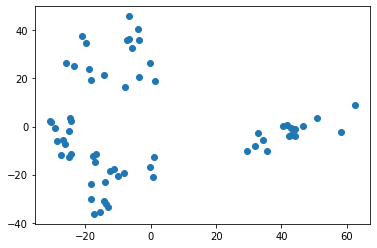

In [36]:
plt.scatter(t_feats[:,0], t_feats[:,1],)

### Plot with Color Legend

In [41]:
player_color = [1 if e <= 5 else 0 for e in y]
d_color = ['orange', 'blue']
player_color = [d_color[e] for e in player_color]

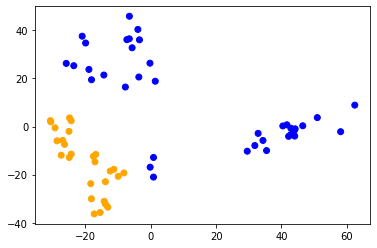

In [42]:
plt.scatter(t_feats[:,0], t_feats[:,1],c=player_color)

In [43]:
vocab = list(train_dl.vocab).copy()

In [50]:
vocab;

In [51]:
vocab_piece = [e.split('-')[-1] for e in vocab]
vocab_piece;

In [52]:
d_color = {'knight': 'orange', 
           'rook':  'blue',
           'pawn': 'red',
           'queen': 'black',
           'king':  'yellow',
           'bishop': 'pink',
           
          
          }

piece_color = [d_color[vocab_piece[e]] for e in y]

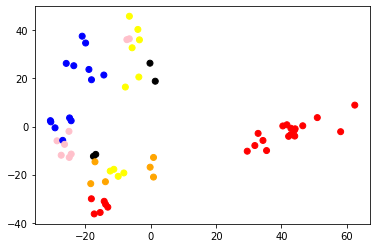

In [53]:
plt.scatter(t_feats[:,0], t_feats[:,1],c=piece_color)

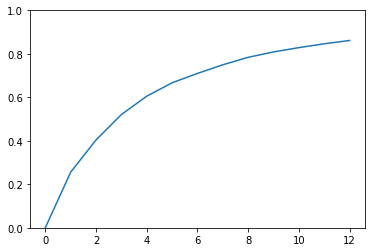

In [65]:
tmp = pca.explained_variance_ratio_.cumsum()
tmp  = [0] + tmp.tolist()
plt.plot(tmp)
plt.ylim(0,1);

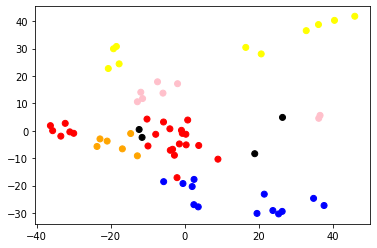

In [66]:
plt.scatter(t_feats[:,1], t_feats[:,2],c=piece_color)

In [70]:
train_dl.tfms[0]

Pipeline: PILBase.create

In [71]:
train_dl.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

In [74]:
train_dl.transform
# train_dl.before_batch

(#2) [(#2) [noop:
encodes: (object,object) -> noopdecodes: ,PILBase.create:
encodes: (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> createdecodes: ],partial:
encodes: (object,object) -> partialdecodes: ]

In [79]:
train_dl.transform[0][1]

PILBase.create:
encodes: (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> createdecodes: 

In [81]:
train_dl.after_item

Pipeline: Resize -- {'size': (128, 128), 'method': 'pad', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor